In [ ]:
# 기본적인 라이브러리(기초세션에서 다룸)
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 문제 1

사용할 데이터 : house.csv

네이버 부동산에서 크롤링해 가져온 서울시 부동산 데이터

* Unnamed: 0 : 의미없는 칼럼
* id : 매물id
> 한 매물당 하나의 id가 할당된다.
* lat : 위도
* lng : 경도
* gu : 구(행정지역정보)
* goodsType : 매물의 거래형태(아파트,빌라 등)
* payType : 판매의 거래형태(월세,매매 등)
* floor : 매물방의 층수
* floor_total : 매물이 있는 전체 건물의 층수
* contractArea : 계약면적
* realArea : 실제면적
* direction : 창문방향(남향,북향)
* tag : 매물마다 관련된 설명정보
> ex. 일조량 및 관리 잘 된 복층
* tagList : 매물마다 관련된 설명에서의 태그
> ex. '10년이내, 25년이내 건축, 복층'과 같이 인스타 해시테그 느낌
* deposit : 보증금
* monthlyPay : 월세


> 데이터 출처 : 네이버 부동산 크롤링 데이터

설명
* X와 y를 찾아, LinearRegression을 위 예제1을 참고하여 실행하시오.
* 예를 들면, y='보증금', X=나머지 으로 하여 나머지 값으로 보증금을 예측하는 선형회귀문제로 Task를 정해 코딩을 진행

* 조건
> * ***(핵심내용)*** X & y로 이용할 것을 명확히 제시하고, y에 따른 어떤 문제인지 파악하기
>    * y를 연속형으로 하여, LinearRegression문제가 될 수 있도록 한다.
> * X변수에 1개이상의 범주형데이터를 포함하고, one-hot encoding을 사용하기
> * 최소 1가지 이상의 방법으로 X데이터 중 1개 이상의 열을 삭제하기
> * 데이터 분할 진행하기
> * ***(핵심내용)*** 다중선형회귀 모델을 사용하기
> * 규제항이 있는 모델(Ridge,Lasso)을 사용하기
> * hyper-parameter 튜닝을 진행하기
>   * cross_val_score를 사용하지 않아도 됩니다.
>   * GridSearchCV ,RandomSearchCV을 사용하셔도 됩니다.
>   * 참고자료 : https://dacon.io/codeshare/
> * ***(핵심내용)*** 변수 중요도 해석
>   * 스케일링 없이
>   * min-max scaling
>   * standard scaling

## 데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/[23-1]_DSL세션/house.csv'
house = pd.read_csv(path, index_col=0)
house.head()

,id,lat,lng,gu,goodsType,payType,floor,floor_total,contractArea,realArea,direction,tag,tagList,deposit,monthlyPay
0,2233636969,37.677967,127.041725,dobong,아파트,매매,5,5,81,63,남향,ok. 일조량 및 관리 잘 된 복층,"['10년이내', '역세권', '복층', '탑층']",63000,0
3,2232935032,37.657623,127.044115,dobong,아파트,매매,15,24,154,119,남향,기본 로얄동 로얄층 채광 GOOD,"['25년이내', '대단지', '대형평수', '방네개이상']",140000,0
4,2232502309,37.645001,127.040034,dobong,빌라,전세,3,4,38,33,남향,올수리 베란다크고 주차 남향 초등학교 대형마트 재래시장 5분,"['25년이상', '융자금적은', '올수리', '화장실한개']",15000,0
5,2232883418,37.666850,127.039420,dobong,아파트,매매,5,18,107,84,남향,내부상태아주좋습니다 방학역세권 도깨비시장근접함 주인거주,"['25년이상', '방세개', '화장실두개', '주차가능']",60000,0
6,2234171117,37.655622,127.041475,dobong,사무실,월세,2,8,30,22,북향,빠른입주가능 상태깨끗 창동역도보7분 사무실강추,"['25년이내', '융자금없는', '주차가능', '북향']",700,44


## 어떤 Task인지 파악하기

데이터 구조 확인 및 어떤 task인지 파악을 한다.

In [ ]:
# (행,열)
# 행의 수 = 데이터(표본)의 갯수 = 93995
# 열의 수 = features들의 갯수 = 16

house.shape

(93995, 15)

In [ ]:
# features 살펴보기

house.columns

Index(['id', 'lat', 'lng', 'gu', 'goodsType', 'payType', 'floor',
       'floor_total', 'contractArea', 'realArea', 'direction', 'tag',
       'tagList', 'deposit', 'monthlyPay'],
      dtype='object')

(array([9.3992e+04, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([       0.,  1215000.,  2430000.,  3645000.,  4860000.,  6075000.,
         7290000.,  8505000.,  9720000., 10935000., 12150000.]),
 <a list of 10 Patch objects>)

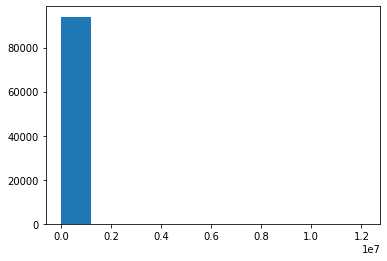

In [ ]:
# y값 = 'monthlyPay(월세)'열

# y(label)값 뜯어내기
y_label = house.loc[:,'monthlyPay']

# y값 분포 확인
y_label.value_counts()
plt.hist(y_label.values)

# 결론
# y값 = exist -> Supervised
# y값 = 연속형 -> regression

In [ ]:
# 위의 y값을 제외한 진정한 X값들로 이루어진 features 만들기

X_features = house.drop(['monthlyPay'], axis=1)
X_features.columns # 10개의 열들이 진정한 X_features로 사용

# 즉, 14개의 X_features열들로 1개의 y_label인 'monthlyPay'를 맞추는 문제
# 여기서 행은 데이터의 갯수, 즉 이러한 갯수의 데이터를 이용해 학습을 시킨다는 의미

Index(['id', 'lat', 'lng', 'gu', 'goodsType', 'payType', 'floor',
       'floor_total', 'contractArea', 'realArea', 'direction', 'tag',
       'tagList', 'deposit'],
      dtype='object')

In [ ]:
# X_features 열들이 ['연속형','범주형']인지 확인

# 1~5번째 행(데이터)
X_features.head()

# 범주형 데이터 : 'gu', 'goodsType', 'payType', 'direction', 'floor', 'floor_total'
# 'floor'랑 'floor_total'은 숫자로 이루어져 있지만 순서가 있는 범주형 데이터로 해석해도 무방할 것 같다.
# 연속형 데이터 : 나머지

,id,lat,lng,gu,goodsType,payType,floor,floor_total,contractArea,realArea,direction,tag,tagList,deposit
0,2233636969,37.677967,127.041725,dobong,아파트,매매,5,5,81,63,남향,ok. 일조량 및 관리 잘 된 복층,"['10년이내', '역세권', '복층', '탑층']",63000
3,2232935032,37.657623,127.044115,dobong,아파트,매매,15,24,154,119,남향,기본 로얄동 로얄층 채광 GOOD,"['25년이내', '대단지', '대형평수', '방네개이상']",140000
4,2232502309,37.645001,127.040034,dobong,빌라,전세,3,4,38,33,남향,올수리 베란다크고 주차 남향 초등학교 대형마트 재래시장 5분,"['25년이상', '융자금적은', '올수리', '화장실한개']",15000
5,2232883418,37.666850,127.039420,dobong,아파트,매매,5,18,107,84,남향,내부상태아주좋습니다 방학역세권 도깨비시장근접함 주인거주,"['25년이상', '방세개', '화장실두개', '주차가능']",60000
6,2234171117,37.655622,127.041475,dobong,사무실,월세,2,8,30,22,북향,빠른입주가능 상태깨끗 창동역도보7분 사무실강추,"['25년이내', '융자금없는', '주차가능', '북향']",700


* 지금까지 배운 모델 중 회귀문제를 풀 수 있는 모델은 '선형회귀'이다.

> * 선형회귀의 경우, X값 중에 범주형 데이터가 있을 경우에
> * label_encoding -> one-hot_encoding으로 바꾸어주어야한다.

> * 범주형 데이터 : 'gu', 'goodsType', 'payType', 'direction', 'floor', 'floor_total'
> * 'floor'랑 'floor_total'은 숫자로 이루어져 있지만 순서가 있는 범주형 데이터로 해석해도 무방할 것 같다.
> * 연속형 데이터 : 나머지

> * 범주형 데이터 중에서 'direction' 변수를 분석에 활용하려고 한다

> * 따라서 'direction' 변수에 대해 one-hot encoding을 진행하려 한다. 

In [ ]:
# 범주형 데이터(gu, direction, payType) 살펴보기

house.loc[:,['gu']].value_counts()

gu          
gangseo         4097
guro            3983
yeongdeungpo    3974
seocho          3958
yangcheon       3902
nowon           3902
songpa          3901
guemcheon       3881
eunpyeong       3833
dobong          3784
gangdong        3784
dongjak         3748
mapo            3742
jungnang        3732
seongdong       3726
yongsan         3705
seongbuk        3703
dongdaemun      3689
gwangjin        3689
jung            3679
gangnam         3669
seodaemun       3661
gwanak          3654
gangbuk         3443
jongno          3156
dtype: int64

In [ ]:
# 범주형 데이터(gu, direction, payType) 살펴보기

house.loc[:,['direction']].value_counts()

direction
남향           29214
남동향          16395
남서향          13189
동향           13111
서향            7084
북향            5091
북동향           3664
북서향           3043
dtype: int64

In [ ]:
# 범주형 데이터(gu, direction, payType) 살펴보기

house.loc[:,['payType']].value_counts()

payType
월세         37803
매매         30918
전세         24918
단기임대         356
dtype: int64

## 데이터 전처리하기(1)
* 결측치 파악

사실상 ML에서는 데이터 전처리를 하는데 가장 오랜시간이 걸린다.

데이터 전처리의 경우, 개인의 논리와 그간의 데이터 분석경험에 따라 어느 정도 바뀌어질 수 있다. 따라서 이번 시간에 제시된 방법이 정답은 아니고, 하나의 방법으로 제시하는 측면이라는 걸 확인해주길 바랍니다.

### 결측치 처리

In [ ]:
# 항상 결측치가 있는지 확인이 필요하다.

house.isnull().sum()

id                 0
lat                0
lng                0
gu                 0
goodsType          0
payType            0
floor              0
floor_total        0
contractArea       0
realArea           0
direction       3204
tag             4529
tagList            0
deposit            0
monthlyPay         0
dtype: int64

질문 : 결측치를 어떻게 처리할 것인가?

범주형 축(direction)의 경우,

아래 2가지 방법 중 1번 방법을 사용하려고 했으나, 코드가 15분 이상 돌아갔다. 따라서 결측치가 있는 행을 없애는 방법으로 진행하려고 한다.

1. 새로운 class를 만들지 않고 기존의 class에 넣을 수 있다.
> 설명 : 해당 축은 '0 or 1'값을 갖는 범주형 feature이다. 따라서 '0 or 1'값이 아닌 새로운 class를 만들지 않고, 기존의 '0 or 1'값으로 null을 채운다. 이 때, 최빈값을 사용하기로 한다. 단, '0 or 1'이 같은 비율로 존재할 경우를 주의하여 이 상황에는 어떻게 할지 고민해볼 것

2. 새로운 class를 만들어, 기존의 class 범주를 확장시켜 null값을 채운다.
> 설명 : null값을 하나의 class로 보고 이 값들만 들어가는 새로운 범주를 만든다. 예를 들면, '0 or 1'이 있기에 같은 정수형 범주인 '2'로 null값을 바꿔주면 된다.


In [ ]:
house.dropna(axis=0, inplace=True)

In [ ]:
# 'hour_bef_precipitation'의 null값 2개가 2로 바뀜으로써, 해당 열의 null값이 0이 됨
house.isnull().sum()

id              0
lat             0
lng             0
gu              0
goodsType       0
payType         0
floor           0
floor_total     0
contractArea    0
realArea        0
direction       0
tag             0
tagList         0
deposit         0
monthlyPay      0
dtype: int64

In [ ]:
# 결측치를 가진 행(데이터)을 일부 삭제하였음으로, 일부 index는 없을 것이다.
# 따라서 결측치를 모두 처리한 데이터의 index를 정리해줌.

house.index

Int64Index([     0,      3,      4,      5,      6,      7,      8,      9,
                10,     11,
            ...
            104988, 104989, 104991, 104992, 104993, 104994, 104995, 104996,
            104998, 104999],
           dtype='int64', length=86553)

In [ ]:
# index 정리

house.reset_index(drop=True, inplace=True) # drop : index열을 만들것인지 여부
house.index

RangeIndex(start=0, stop=86553, step=1)

## 데이터 전처리하기(2)
* 범주형 X 데이터 처리 및 변수제거

사실상 ML에서는 데이터 전처리를 하는데 가장 오랜시간이 걸린다.

### 1. 범주형 X데이터 처리

* 'direction'열의 경우, 범주형이나 [남향,남동향,남서향,북서향,북동향,동향,서향,북향]형태로 label_encoding이 되어있다.
* 'gu', 'payType' 도 똑같이 one-hot_encoding을 진행한다
* 따라서 one-hot_encoding을 해주어야 앞으로의 계산이 올바르다.

In [ ]:
# label_encoding된 'direction'열

house.loc[:,'direction']

0         남향
1         남향
2         남향
3         남향
4         북향
        ... 
86548     남향
86549     남향
86550    남동향
86551     북향
86552     남향
Name: direction, Length: 86553, dtype: object

In [ ]:
# one-hot_encoding된 'direction'열

temp1 = pd.get_dummies(house.loc[:,'direction'])
temp1

,남동향,남서향,남향,동향,북동향,북서향,북향,서향
0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
86548,0,0,1,0,0,0,0,0
86549,0,0,1,0,0,0,0,0
86550,1,0,0,0,0,0,0,0
86551,0,0,0,0,0,0,1,0


In [ ]:
# 새로 encoding한 데이터로 바꿔주기

house = house.drop(['direction'], axis=1)
house = pd.concat([house, temp1], axis=1)
house.head()

,id,lat,lng,gu,goodsType,payType,floor,floor_total,contractArea,realArea,...,deposit,monthlyPay,남동향,남서향,남향,동향,북동향,북서향,북향,서향
0,2233636969,37.677967,127.041725,dobong,아파트,매매,5,5,81,63,...,63000,0,0,0,1,0,0,0,0,0
1,2232935032,37.657623,127.044115,dobong,아파트,매매,15,24,154,119,...,140000,0,0,0,1,0,0,0,0,0
2,2232502309,37.645001,127.040034,dobong,빌라,전세,3,4,38,33,...,15000,0,0,0,1,0,0,0,0,0
3,2232883418,37.666850,127.039420,dobong,아파트,매매,5,18,107,84,...,60000,0,0,0,1,0,0,0,0,0
4,2234171117,37.655622,127.041475,dobong,사무실,월세,2,8,30,22,...,700,44,0,0,0,0,0,0,1,0


In [ ]:
# 변경된 'y_label', 'X_features' 만들기

y_label = house.loc[:,'monthlyPay']
X_features = house.drop(['monthlyPay'], axis=1)

### 2-0. 의미없는 변수제거

'id','tag','tagList' 변수의 경우
분석에 유의미하지 않을 것이라 판단되므로 삭제하기로 결정
나머지 범주형 변수인 gu와 payType, goodsType도 삭제

In [ ]:
X_features= X_features.drop(['id','tag','tagList','gu','payType','goodsType'],axis=1)
X_features.columns

Index(['lat', 'lng', 'floor', 'floor_total', 'contractArea', 'realArea',
       'deposit', '남동향', '남서향', '남향', '동향', '북동향', '북서향', '북향', '서향'],
      dtype='object')

### 2-1. 다중공선성으로 변수 제거

다중공선성이 있는 X변수를 제거한다.


여러가지 회귀 모델 중 선형회귀모형을 사용하도록 한다. 선형회귀모형을 사용할 때, 다중공선성을 통해 X_features들을 골라낼 수 있다.

#### 2-1-1. 상관계수를 살펴본다.(상관행렬 이용)
* 변수 제거 후에는 X2_features로 새로 지정

1. X_features들의 서로 다른 축들 중에 서로의 상관관계가 높은 것을 찾는다.
* 상관관계가 높은 두 축은 다른 축으로 설명이 가능하다는 뜻임으로, 두 개를 모두 이용하지 않고 1개만 사용하자.

2. 서로 상관관계가 높은 것들 중 y_label과의 상관관계가 높은 것을 남겨두고, 낮은 것을 제거한다.
* 즉, 서로가 서로를 설명할 수 있는 X_features내의 두 축에 대하여 어떤 것을 남길지에 대한 기준을 정해야한다. 이 때, y값과의 상관계수값이 더 큰 것을 남기도록 한다.
* 향후, 배울 차원축소에서 '변수선택'의 한 기법(mRMR)에서 비슷하게 적용된다.

새로운 X_features를 X2_features라 하자.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54693 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_

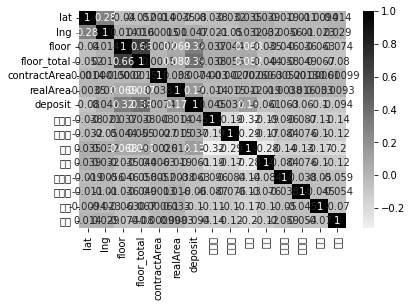

In [ ]:
# 1. X_features들의 서로 다른 축들 중에 서로의 상관관계가 높은 것을 찾는다.
# sns라이브러리를 통해 시각적으로 확인
# 색깔이 진할수록 상관관계가 높다.

cmap = sns.light_palette(color="black", as_cmap=True)
sns.heatmap(X_features.corr(), annot=True, cmap=cmap)
plt.show()

In [ ]:
# pandas내부의 corr()함수를 통해 수치적으로 정확히 확인

cor_matrix = abs(X_features.corr())

for i in range(len(cor_matrix.columns)):
    cor_matrix.iloc[i,i] = 0

cor_matrix

,lat,lng,floor,floor_total,contractArea,realArea,deposit,남동향,남서향,남향,동향,북동향,북서향,북향,서향
lat,0.000000,0.281668,0.039507,0.051532,0.001412,0.003542,0.079696,0.038061,0.031995,0.034759,0.038706,0.018920,0.010905,0.009442,0.014482
lng,0.281668,0.000000,0.013707,0.015983,0.000154,0.010164,0.047124,0.020709,0.050245,0.031988,0.032026,0.005592,0.010372,0.023007,0.028771
floor,0.039507,0.013707,0.000000,0.657588,0.000196,0.069165,0.315507,0.037461,0.044391,0.068336,0.035089,0.046004,0.036126,0.063279,0.073567
floor_total,0.051532,0.015983,0.657588,0.000000,0.001461,0.086724,0.385687,0.038246,0.055174,0.081758,0.044416,0.057602,0.048823,0.067488,0.079523
contractArea,0.001412,0.000154,0.000196,0.001461,0.000000,0.037964,0.007440,0.003003,0.002735,0.002603,0.006283,0.005196,0.001302,0.000614,0.000993
realArea,0.003542,0.010164,0.069165,0.086724,0.037964,0.000000,0.172329,0.014370,0.015467,0.012114,0.019219,0.003820,0.016091,0.032518,0.009324
deposit,0.079696,0.047124,0.315507,0.385687,0.007440,0.172329,0.000000,0.045164,0.037189,0.133855,0.060793,0.063494,0.060362,0.101527,0.094024
남동향,0.038061,0.020709,0.037461,0.038246,0.003003,0.014370,0.045164,0.000000,0.193787,0.323690,0.192933,0.095672,0.086714,0.113897,0.136036
남서향,0.031995,0.050245,0.044391,0.055174,0.002735,0.015467,0.037189,0.193787,0.000000,0.285277,0.170037,0.084318,0.076423,0.100381,0.119892
남향,0.034759,0.031988,0.068336,0.081758,0.002603,0.012114,0.133855,0.323690,0.285277,0.000000,0.284020,0.140840,0.127653,0.167670,0.200260


In [ ]:
# 상관계수값이 높은 순대로 정렬

np.sort(cor_matrix.values.flatten())[::-1]

# corr(a,b) = corr(b,a)임으로 똑같은 값이 2개씩 나온다.

array([6.57587547e-01, 6.57587547e-01, 3.85687230e-01, 3.85687230e-01,
       3.23690372e-01, 3.23690372e-01, 3.15507028e-01, 3.15507028e-01,
       2.85277313e-01, 2.85277313e-01, 2.84019619e-01, 2.84019619e-01,
       2.81668351e-01, 2.81668351e-01, 2.00260022e-01, 2.00260022e-01,
       1.93787272e-01, 1.93787272e-01, 1.92932928e-01, 1.92932928e-01,
       1.72329353e-01, 1.72329353e-01, 1.70037147e-01, 1.70037147e-01,
       1.67670276e-01, 1.67670276e-01, 1.40840102e-01, 1.40840102e-01,
       1.36035505e-01, 1.36035505e-01, 1.33855318e-01, 1.33855318e-01,
       1.27653086e-01, 1.27653086e-01, 1.19891868e-01, 1.19891868e-01,
       1.19363304e-01, 1.19363304e-01, 1.13897474e-01, 1.13897474e-01,
       1.01526601e-01, 1.01526601e-01, 1.00381007e-01, 1.00381007e-01,
       9.99384603e-02, 9.99384603e-02, 9.56718883e-02, 9.56718883e-02,
       9.40237353e-02, 9.40237353e-02, 8.67243895e-02, 8.67243895e-02,
       8.67140227e-02, 8.67140227e-02, 8.43182918e-02, 8.43182918e-02,
      

In [ ]:
# 상관계수값이 가장 큰 두 축을 찾기

idx = np.where(cor_matrix == cor_matrix.max().max())[0]
print('columns of max corr : {} & {}'.format(cor_matrix.columns[idx[0]], cor_matrix.columns[idx[1]]))

columns of max corr : floor & floor_total


floor와 floor_total이 상관 계수가 높았음

In [ ]:
# floor보다는 floor_total이 덜 중요할 것 같으므로, 이를 제외하고 진행한다

X_features= X_features.drop(['floor_total'],axis=1)
X_features.columns

Index(['lat', 'lng', 'floor', 'contractArea', 'realArea', 'deposit', '남동향',
       '남서향', '남향', '동향', '북동향', '북서향', '북향', '서향'],
      dtype='object')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54693 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_

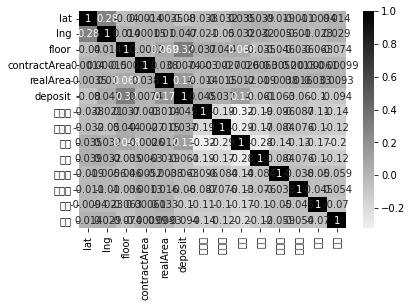

In [ ]:
# 1. X_features들의 서로 다른 축들 중에 서로의 상관관계가 높은 것을 찾는다.
# sns라이브러리를 통해 시각적으로 확인
# 색깔이 진할수록 상관관계가 높다.

cmap = sns.light_palette(color="black", as_cmap=True)
sns.heatmap(X_features.corr(), annot=True, cmap=cmap)
plt.show()

In [ ]:
# pandas내부의 corr()함수를 통해 수치적으로 정확히 확인

cor_matrix = abs(X_features.corr())

for i in range(len(cor_matrix.columns)):
    cor_matrix.iloc[i,i] = 0

cor_matrix

,lat,lng,floor,contractArea,realArea,deposit,남동향,남서향,남향,동향,북동향,북서향,북향,서향
lat,0.000000,0.281668,0.039507,0.001412,0.003542,0.079696,0.038061,0.031995,0.034759,0.038706,0.018920,0.010905,0.009442,0.014482
lng,0.281668,0.000000,0.013707,0.000154,0.010164,0.047124,0.020709,0.050245,0.031988,0.032026,0.005592,0.010372,0.023007,0.028771
floor,0.039507,0.013707,0.000000,0.000196,0.069165,0.315507,0.037461,0.044391,0.068336,0.035089,0.046004,0.036126,0.063279,0.073567
contractArea,0.001412,0.000154,0.000196,0.000000,0.037964,0.007440,0.003003,0.002735,0.002603,0.006283,0.005196,0.001302,0.000614,0.000993
realArea,0.003542,0.010164,0.069165,0.037964,0.000000,0.172329,0.014370,0.015467,0.012114,0.019219,0.003820,0.016091,0.032518,0.009324
deposit,0.079696,0.047124,0.315507,0.007440,0.172329,0.000000,0.045164,0.037189,0.133855,0.060793,0.063494,0.060362,0.101527,0.094024
남동향,0.038061,0.020709,0.037461,0.003003,0.014370,0.045164,0.000000,0.193787,0.323690,0.192933,0.095672,0.086714,0.113897,0.136036
남서향,0.031995,0.050245,0.044391,0.002735,0.015467,0.037189,0.193787,0.000000,0.285277,0.170037,0.084318,0.076423,0.100381,0.119892
남향,0.034759,0.031988,0.068336,0.002603,0.012114,0.133855,0.323690,0.285277,0.000000,0.284020,0.140840,0.127653,0.167670,0.200260
동향,0.038706,0.032026,0.035089,0.006283,0.019219,0.060793,0.192933,0.170037,0.284020,0.000000,0.083947,0.076087,0.099938,0.119363


In [ ]:
# 상관계수값이 높은 순대로 정렬

np.sort(cor_matrix.values.flatten())[::-1]

# corr(a,b) = corr(b,a)임으로 똑같은 값이 2개씩 나온다.

array([3.23690372e-01, 3.23690372e-01, 3.15507028e-01, 3.15507028e-01,
       2.85277313e-01, 2.85277313e-01, 2.84019619e-01, 2.84019619e-01,
       2.81668351e-01, 2.81668351e-01, 2.00260022e-01, 2.00260022e-01,
       1.93787272e-01, 1.93787272e-01, 1.92932928e-01, 1.92932928e-01,
       1.72329353e-01, 1.72329353e-01, 1.70037147e-01, 1.70037147e-01,
       1.67670276e-01, 1.67670276e-01, 1.40840102e-01, 1.40840102e-01,
       1.36035505e-01, 1.36035505e-01, 1.33855318e-01, 1.33855318e-01,
       1.27653086e-01, 1.27653086e-01, 1.19891868e-01, 1.19891868e-01,
       1.19363304e-01, 1.19363304e-01, 1.13897474e-01, 1.13897474e-01,
       1.01526601e-01, 1.01526601e-01, 1.00381007e-01, 1.00381007e-01,
       9.99384603e-02, 9.99384603e-02, 9.56718883e-02, 9.56718883e-02,
       9.40237353e-02, 9.40237353e-02, 8.67140227e-02, 8.67140227e-02,
       8.43182918e-02, 8.43182918e-02, 8.39465603e-02, 8.39465603e-02,
       7.96955606e-02, 7.96955606e-02, 7.64234761e-02, 7.64234761e-02,
      

In [ ]:
# 상관계수값이 가장 큰 두 축을 찾기

idx = np.where(cor_matrix == cor_matrix.max().max())[0]
print('columns of max corr : {} & {}'.format(cor_matrix.columns[idx[0]], cor_matrix.columns[idx[1]]))

columns of max corr : 남동향 & 남향


## 데이터 분할
* train_X, train_y : 모델 학습을 위한 데이터
* test_X, test_y : 학습된 모델을 평가하기 위한 데이터

학습, 테스트 데이터 8:2비율로 분할 
* random state=1 으로 지정

In [ ]:
from sklearn.model_selection import train_test_split

# X3_features 사용; X4_features의 경우, 학습이후에 만들어진 데이터임으로

train_X, test_X, train_y, test_y = train_test_split(X_features, y_label, train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(69242, 14) (17311, 14) (69242,) (17311,)


## 1. LinearRegression

* 사용한 모델 : 규체항이나 다항회귀 없이, 그냥 쌩 다중선형회귀
* 학습방법 : 학습데이터로 학습 후, 테스트데이터로 평가

RMSE: 621.907, MAE: 400.401


<BarContainer object of 2 artists>

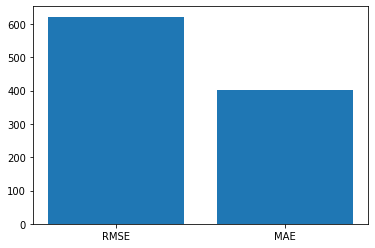

In [ ]:
from sklearn.linear_model import LinearRegression

# Model
lr_model = LinearRegression()
lr_model.fit(train_X, train_y) # 최적화식을 풀어 학습파라미티(회귀계수)를 구한다.
pred = lr_model.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

## 2.  Ridge, Lasso

* 사용한 모델
> * Ridge : 회귀계수의 크기를 0으로 가깝게 하여, X를 완전히 제거하지 않고 살려두기 위한 모델
> * Lasso : 회귀계수의 크기를 그냥 0으로 만들어버려, X를 완전히 제거하는 모델

* 학습방법
> * 모델을 하이퍼라미터 값을 변경해가면서 10-Fold를 통해 학습데이터 평가. 즉, 학습데이터를 학습과 검증데이터로 쪼개는 과정을 반복하여 학습시키는 방법
>   * 참고 : https://huidea.tistory.com/30
> * 하이퍼라미터 후보 : alpha = [0.001, 0.01, 0.1, 1, 10]
>   * 하이퍼파라미터 선택을 위한 평가지표 : R2_score
>   * 참고 : R2_score의 경우, 선형회귀에서만 사용할 수 있는 지표이다. 즉, 다른 회귀모델에서는 사용불가.

* summary
> * 그냥 학습
>   * 학습에 사용하는 데이터 = train_X, train_y
>   * 테스트에 사용하는 데이터 = test_X, test_y
> * k-fold 학습
>   * 학습에 사용하는 데이터 = train_X, train_y
>   * 테스트에 사용하는 데이터 = train_X, train_y
> * k-fold를 사용하는 이유
>   * 데이터의 수가 너무 적어, test_X, test_y를 만들기 어려운 경우
>   * 하이퍼파라미터를 찾을 시에, test_X, test_y을 잘 예측하는 모델이 아닌 train_X, train_y을 잘 예측하는 모델로 하여, 과적합을 막기 위함

In [ ]:
# 데이터 전처리에 사용되는 라이브러리
from sklearn.model_selection import cross_val_score

# 규제항이 있는 선형회귀 관련 라이브러리
from sklearn.linear_model import Ridge, Lasso

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.34908e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.35606e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.38072e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.25861e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

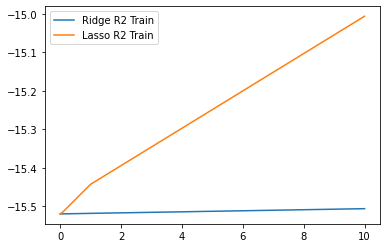

In [ ]:
# hyper-parameter 후보
alpha_list = [0.001, 0.01, 0.1, 1, 10]


# 모델 평가와 관련된 라이브러리
from sklearn import metrics
from sklearn.metrics import r2_score # R^2

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train = []
ridge_r2_list_test = []
lasso_r2_list_train = []
lasso_r2_list_test = []

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)
    


    # # 이전처럼 'k-fold학습'을 쓰지 않고, 그냥 학습
    # ridge_model.fit(train_X,train_y)
    # lasso_model.fit(train_X,train_y)
    # #테스트; sklearn.metrics에 있는 r2_score()함수를 가져와 평가
    # ridge_r2_list_test.append(r2_score(test_y,ridge_model.predict(test_X)))
    # lasso_r2_list_test.append(r2_score(test_y,lasso_model.predict(test_X)))


    # kfold 통해 성능평가; 즉, train_set을 8:2로 나누는 것을 10번 반복해서 학습을 진행하는 것이다.
    # cross_val_score()에서 scoring='r2'로 두고 평가
    # 즉, train_set만을 가지고 학습 및 평가(검증)를 진행한다.
    # test_set은 사용하지 않는다.
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge_model,train_X,train_y,scoring='r2',cv=10)))
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso_model,train_X,train_y,scoring='r2',cv=10)))
    
    

plt.plot(alpha_list, ridge_r2_list_train, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train, label='Lasso R2 Train')

plt.legend()

# r2지표는 높을수록 좋음으로, Ridge&Lasso 모두 alpha=0.001일 때 가장 모델의 성능이 좋다.

In [ ]:
# 차례로 'alpha = [0.001, 0.01, 0.1, 1, 10]'을 했을 때, Ridge모델에 대한 r2평가지표
ridge_r2_list_train

[-15.519917045594223,
 -15.519904088680846,
 -15.51977459484847,
 -15.518487133353934,
 -15.506310541101678]

In [ ]:
# 차례로 'alpha = [0.001, 0.01, 0.1, 1, 10]'을 했을 때, Lasso모델에 대한 r2평가지표
lasso_r2_list_train

[-15.519860320237338,
 -15.51930953722604,
 -15.51415464133349,
 -15.442954455201601,
 -15.006086930307777]

가장 좋은 성능이 나온 hyper-parameter값을 기준으로 모델을 제작한다.
* 이전에는 반복문을 사용하여 가장 마지막 모델이 변수안에 들어갔기에, 다시 학습이 필요함

In [ ]:
# 가장 성능이 좋은 모델의 hyper-parameter 확인

idx1 = np.array(ridge_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index
idx2 = np.array(lasso_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index

print('Ridge best alpha :', alpha_list[idx1])
print('Lasso best alpha :', alpha_list[idx2])

Ridge best alpha : 10
Lasso best alpha : 10


각각 최적이 hyper-parameter로 학습한 후에 Ridge와 Lasso의 성능을 서로 비교하자.
* 이번에는 R2_score뿐만 아니라, 일반적으로 회귀모델들의 평가지표로써 사용되는 r-MSE & MAE도 함께 사용

In [ ]:
# 각각 alpha = 10, 10으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge = Ridge(alpha=10) # 'fit_intercept=True' : 절편을 넣어줄지에 대한 여부
lasso = Lasso(alpha=10)

# 모델 학습; 이번에는 학습데이터를 학습&검증데이터로 나누는 것이 아닌
# 학습데이터로 학습하고, 테스트데이터로 테스트를 한다.
ridge.fit(train_X, train_y)
lasso.fit(train_X, train_y)

# 모델 평가
# R^2; r2_score
# 여기서 매우 조심해야할 사항이 있다.
# 그것은 바로 r2_score()와 mean_squared_error() 모두 인자의 순서를 주의해서 넣어주어야한다는 것이다.
# 모두 (정닶값,예측값) 순으로 넣어주어야한다.
# mse는 어차피 같은 값이 나오지만, r2_score는 조심해야한다.
print("R square score for Ridge model : {:.5f}".format(r2_score(test_y, ridge.predict(test_X))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y, lasso.predict(test_X))))

# MSE; mean_squared_error
print("MSE for Ridge model : {:.5f}".format(mean_squared_error(test_y, ridge.predict(test_X))))
print("MSE for Lasso model : {:.5f}".format(mean_squared_error(test_y, lasso.predict(test_X))))

R square score for Ridge model : 0.03698
R square score for Lasso model : 0.12306
MSE for Ridge model : 384899.44880
MSE for Lasso model : 350493.40257


RMSE: 620.403, MAE: 398.455


<BarContainer object of 2 artists>

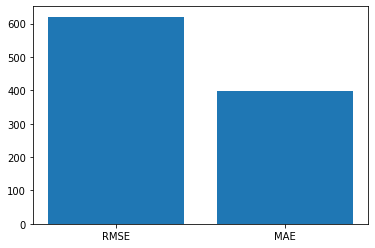

In [ ]:
pred = ridge.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

RMSE: 592.025, MAE: 361.352


<BarContainer object of 2 artists>

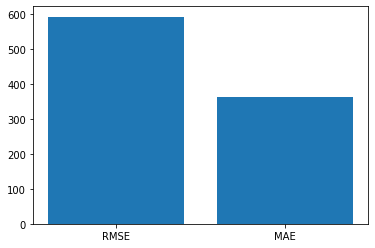

In [ ]:
pred = lasso.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

Lasso가 Ridge보다  R2_score값은 높고 RMSE값은 낮기에 더 좋은 모델이다. 따라서 해당 Lasso 모델을 선택한다.

## 변수중요도 : 회귀계수에 대한 해석

ML에서는 NN과 달리 어느 정도 설명가능한 부분이 있다. 그 중 하나가 바로 변수 중요도이다.

> 일반적으로 회귀계수의 크기가 클수록 해당 X변수의 중요도가 높다. 하지만 회귀계수의 의미를 생각하면, X변수를 스케일링에 따라 다르게 해석할 수 있다.(세션자료 참고)

> 1. 스케일링 없이
>    * 1000원짜리 김밥 1원 증가할 때와 10억원짜리 집값 1원 증가할 때, 경제지표에 미치는 영향
> 2. min-max scaling
>    * 1000원짜리 김밥가격 10% 증가할 때와 10억원짜리 집값 10% 증가할 때, 경제지표에 미치는 영향
> 3. standard scaling
>    * 데이터로 얻은 각각의 김밥과 집값의 분포에서 z-score가 일정부분 동일하게 움직였을 때의 가격 변화가 경제지표에 미치는 영향

최종적으로 선택해서 학습까지 완료시킨 lasso모델을 사용

1. 스케일링 없이

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54693 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48513 missing from current font.
  font.set_text(s, 0.0, flags=f

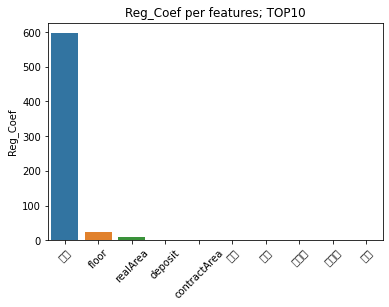

In [ ]:
# 표준화한 회귀계수의 절댓값
coef = lasso.coef_
coef_abs = np.abs(coef)

# 회귀계수의 절댓값 크기 index
idx = coef_abs.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs = coef_abs[idx]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name = X_features.head(1).columns[idx].values

# top10
sns.barplot(name[0:10], coef_abs[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

In [ ]:
lasso.coef_

array([ 0.00000000e+00,  0.00000000e+00, -2.34364791e+01,  1.32646847e-03,
        7.97238973e+00, -3.87920771e-03,  0.00000000e+00,  0.00000000e+00,
        5.97039642e+02, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00])

2. min-max scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

total_data = pd.concat([X_features, y_label], axis=1)

scaler = MinMaxScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,lat,lng,floor,contractArea,realArea,deposit,남동향,남서향,남향,동향,북동향,북서향,북향,서향,monthlyPay
0,0.957812,0.627131,0.074627,0.000059,0.005172,0.02625,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


이후, 이전처럼 '데이터분할 -> 최적의 hyper-parameter선택 -> 선택된 모델로 학습 -> 변수중요도 확인' 과정을 수행

3. standard scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

total_data = pd.concat([X3_features, y_label], axis=1)

scaler = StandardScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hbp2,hbp3,monthlyPay
0,1.198579,-0.114422,-0.720969,1.855885,-1.459377,-0.628003,0.599678,5.705261,-0.072412,-0.007175


In [ ]:
lasso.coef_

array([ 0.00000000e+00,  0.00000000e+00, -2.34364791e+01,  1.32646847e-03,
        7.97238973e+00, -3.87920771e-03,  0.00000000e+00,  0.00000000e+00,
        5.97039642e+02, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00])

# 이론 문제

(직접 종이나 아이패드에 써서 코랩에 이미지 파일로 업로드 해주시면 됩니다)

**1.SVM의 수리적 모델링에서, 목적함수를 적고 증명과정을 서술하시오**

**2. 시그모이드 함수의 공식, 정의역, 치역을 작성하시오**

**3. 코드 실습 영상을 참고하여, 아래 그림과 같은 데이터의 F1-score를 계산하시오**


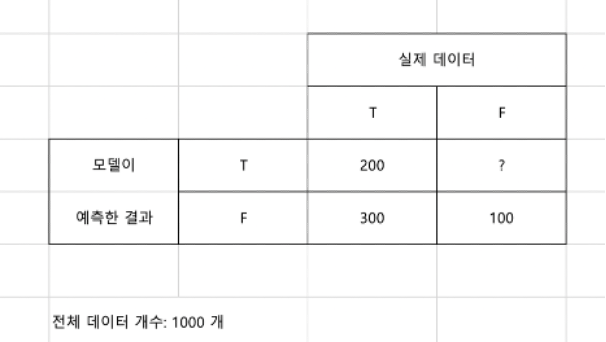

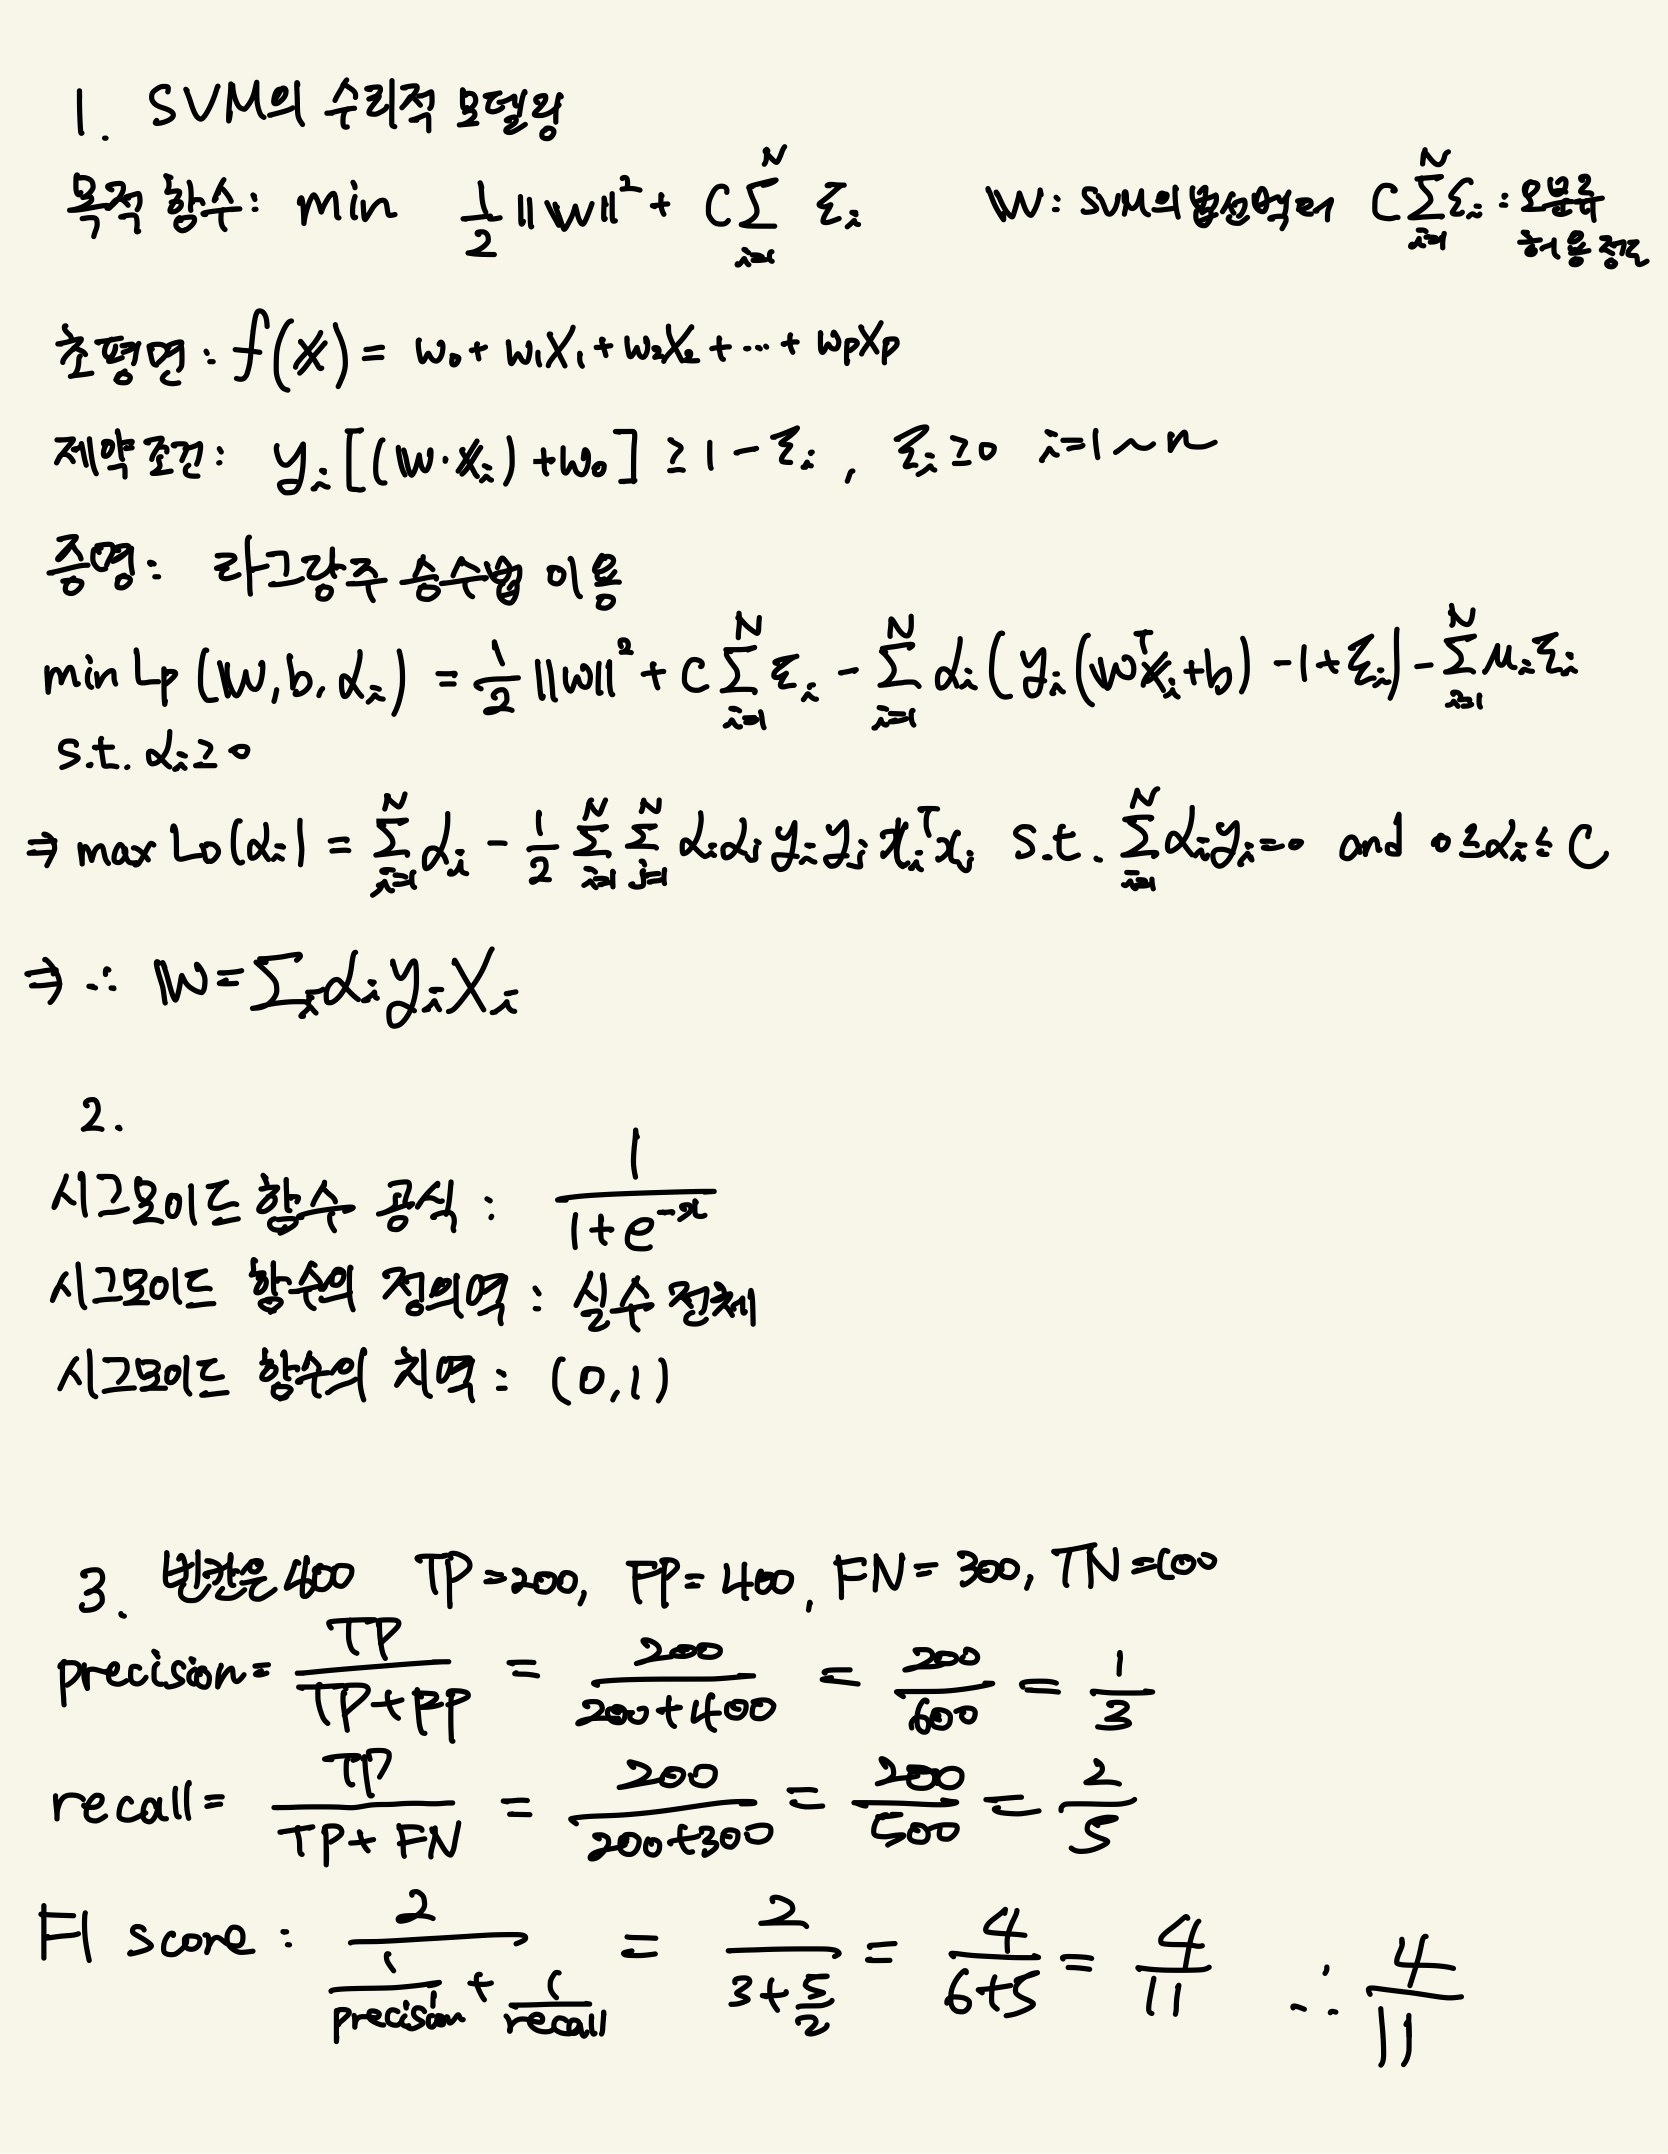